### 문제
- data 폴더 안에 bodyPerformance.csv 파일을 로드 
- 데이터중 object 형 데이터의 컬럼들은 LabelEncoder를 이용하여 라벨링
- 독립, 종속 변수로 데이터를 나눠준다. 
- train, test 데이터를 8:2의 비율로 나눠준다. 
- 독립 데이터들은 StandardScaler를 이용하여 스케일링
- 생성된 변수 4개를 Tensor의 형태로 변환
- torch의 분류 분석을 통해서 데이터 학습 
    - 손실함수는 Adam을 사용하고 lr의 값은 0.01로 설정 
    - 반복 학습의 횟수는 200회 loss값 확인
- 반복 학습이 끝나면 정확도를 확인


In [1]:
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd 

In [2]:
# 데이터 로드 
df = pd.read_csv("../data/bodyPerformance.csv")

In [ ]:
df.info()

In [7]:
# Object 형 컬럼을 선택하여 LabelEncoder를 사용하여 라벨링 
# Str형태의 데이터를 Int형태로 자동 변환 

cols = df.select_dtypes('object').columns.tolist()

for col in cols:
    # LabelEncoder 생성 
    le = LabelEncoder()
    # 각각 컬럼의 데이터들을 le에 학습하고 변환 
    df[col] = le.fit_transform(df[col].values)

In [ ]:
df.head()

In [9]:
# 해당 데이터를 이용하여 분류 분석 -> 정확도가 얼마나 되는가? -> 분류의 개수를 확인 
# class 컬럼의 데이터들의 종류
df['class'].unique()

array([2, 0, 1, 3])

In [32]:
# 독립, 종속으로 데이터를 분할
X = df.drop('class', axis=1).values
Y = df['class'].values
print(type(X), type(Y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [33]:
# train, test 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [34]:
print(type(X_train), type(Y_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [35]:
# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
print(type(X_train), type(Y_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [37]:
# Tensor 타입으로 데이터를 타입 변경 
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [38]:
# CrossEntropyLoss에서 사용할 데이터의 타입을 설정 -> long
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

In [74]:
# 모델 정의 
class Bodycls(nn.Module):
    def __init__(self, _dim):
        # _dim : 입력 데이터의 피쳐의 개수를 받아오기 위한 매개변수
        super(Bodycls, self).__init__()
        # Sequential() -> 여러개의 층을 순서대로 실행
        self.model = nn.Sequential(
            nn.Linear(_dim, _dim * 3),      # 11차원의 입력데이터, 22차원의 출력데이터 생성
            # 비선형 활성화 함수 (ReLU, Sigmoid, Tanh)
            nn.ReLU(),
            nn.Linear(_dim * 3, _dim * 2), 
            nn.ReLU(),
            nn.Linear(_dim * 2, 4)
        )
        # self.model = nn.Linear(_dim, 4)

    def forward(self, x):
        return self.model(x)

In [75]:
# 모델을 생성 
body_model = Bodycls(X_train.shape[1])

In [76]:
# 손실, 옵티마이저 생성 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(body_model.parameters(), lr = 0.01)

In [79]:
# 반복 학습 
body_model.train()
for epoch in range(200):
    out = body_model(X_train_tensor)
    loss = criterion(out, Y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 40 == 0:
        print(f'Epoch : {epoch + 1}, Loss : {round(loss.item(), 4)}')

Epoch : 40, Loss : 0.5568
Epoch : 80, Loss : 0.549
Epoch : 120, Loss : 0.5427
Epoch : 160, Loss : 0.5374
Epoch : 200, Loss : 0.5342


In [80]:
# 평가 모드 진입 
body_model.eval()
with torch.no_grad():
    out = body_model(X_test_tensor)
    _, pred = torch.max(out, 1)    # 가장 높은 클래스를 선택 
    acc = accuracy_score(Y_test, pred)

print(f'{round(acc * 100, 2)}%')

75.63%


In [81]:
# 비선형 활성화 함수 비교

import matplotlib.pyplot as plt

# sin 데이터를 하나 생성
x = torch.linspace(-3, 3, 200).unsqueeze(1)
y = torch.sin(x)

In [82]:
linear_model = nn.Sequential(
    nn.Linear(1, 16), 
    nn.Linear(16, 1)
)

In [84]:
relu_model = nn.Sequential(
    nn.Linear(1, 16), 
    nn.ReLU(), 
    nn.Linear(16, 1)
)

In [85]:
loss = nn.MSELoss()

opt1 = optim.Adam(linear_model.parameters(), lr = 0.01)
opt2 = optim.Adam(relu_model.parameters(), lr = 0.01)

In [86]:
# 반복 학습 
for epoch in range(3000):
    # 선형 모델
    pred1 = linear_model(x)
    loss1 = loss(pred1, y)
    opt1.zero_grad()
    loss1.backward()
    opt1.step()

    # 비선형 모델
    pred2 = relu_model(x)
    loss2 = loss(pred2, y)
    opt2.zero_grad()
    loss2.backward()
    opt2.step()

In [87]:
# 예측 결과 
linear_pred = linear_model(x).detach()
relu_pred = relu_model(x).detach()

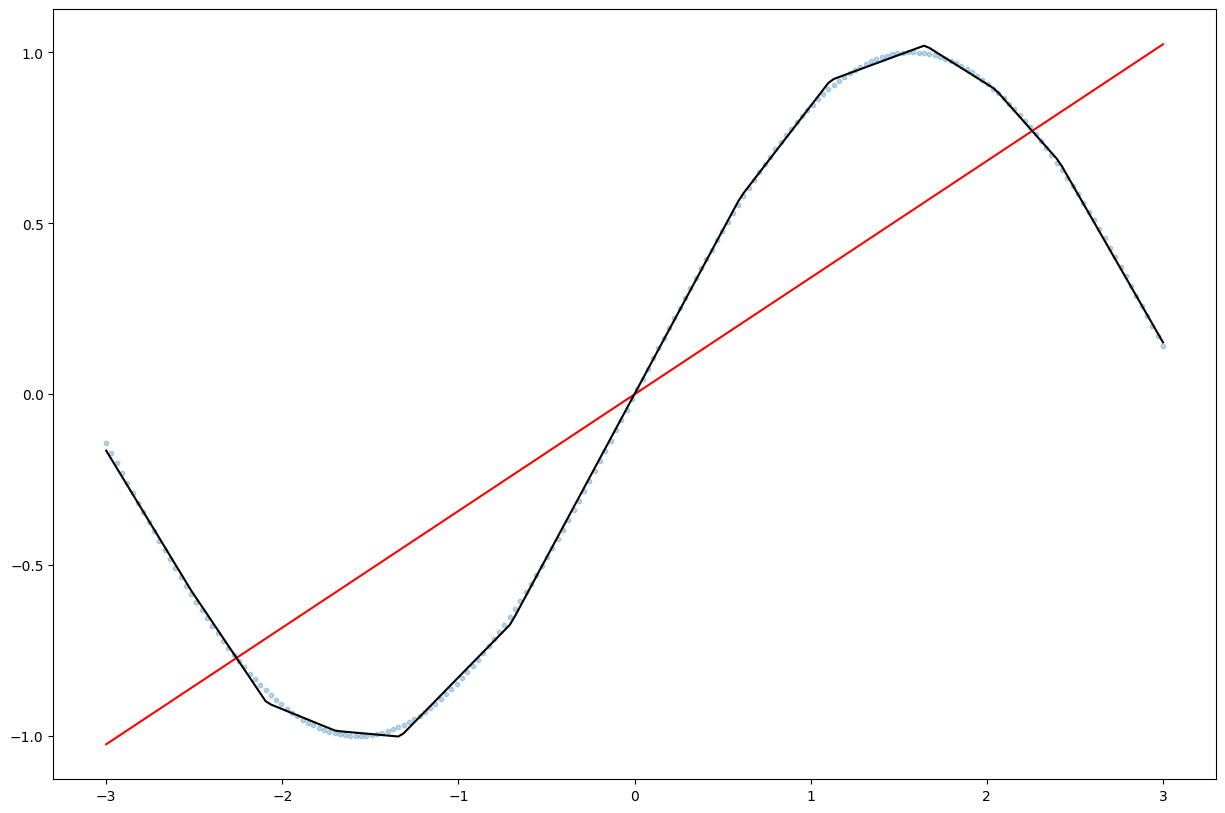

In [93]:
# 시각화 
plt.figure(figsize=(15, 10))

# 원본 데이터 산점도 그래프
plt.scatter(x, y, s = 10, alpha=0.3, label = 'Origin Data')
# 선형 모델 예측 값 -> 라인 그래프 
plt.plot(x, linear_pred, color = 'red')
# 비선형 모델의 예측 값 -> 라인그래프
plt.plot(x, relu_pred, color = 'black')
